<a href="https://colab.research.google.com/github/DilemmaFixer3/AI_labs/blob/main/lab_3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1.1 Встановлення та імпорт бібліотек
!pip install scikit-learn tensorflow keras-tuner deap

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, precision_recall_curve
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from deap import base, creator, tools, algorithms
import random
import matplotlib.pyplot as plt

# 1.2 Завантаження даних
# Припускаємо, що файл 'creditcard.csv' вже завантажено в середовище Colab
try:
    df = pd.read_csv('creditcard.csv')
except FileNotFoundError:
    print("Помилка: файл 'creditcard.csv' не знайдено. Переконайтеся, що він завантажений.")
    exit()

print("Дані завантажено. Перші 5 рядків:")
print(df.head())

# Перевірка дисбалансу
fraud_count = df['Class'].sum()
total_count = len(df)
print(f"\nЗагальна кількість транзакцій: {total_count}")
print(f"Кількість шахрайських транзакцій: {fraud_count} ({fraud_count/total_count:.4%})")

# Визначення ознак
FEATURES = df.columns.drop(['Time', 'Class']).tolist()
TARGET = 'Class'

X = df[FEATURES]
y = df[TARGET]

Дані завантажено. Перші 5 рядків:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

In [8]:
# 2.1 Часово-префіксне розбиття (припускаємо, що дані вже відсортовані за часом)
# Train 70%, Val 15%, Test 15%
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=test_ratio, shuffle=False
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=val_ratio/(train_ratio + val_ratio), shuffle=False
)

print(f"\nРозміри наборів: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

# --- 2.2 Очищення та Препроцесинг (Виправлений код) ---

# 2.2.1 Функція очищення даних від NaN у мітках
def clean_data(X, y, target_name):
    """Видаляє рядки з NaN у цільовій мітці."""
    combined = X.copy()
    combined[target_name] = y.copy()

    initial_len = len(combined)
    # Перевіряємо та видаляємо NaN у цільовому стовпці
    if combined[target_name].isnull().any():
        combined.dropna(subset=[target_name], inplace=True)
        final_len = len(combined)
        print(f"Попередження: Видалено {initial_len - final_len} рядків з NaN у мітці {target_name}.")

    # Видаляємо лише числовий NaN з ознак (за потреби)
    combined.fillna(combined.mean(), inplace=True)

    return combined.drop(columns=[target_name]), combined[target_name]

# Застосовуємо очищення до всіх наборів перед масштабуванням
X_train, y_train = clean_data(X_train, y_train, TARGET)
X_val, y_val = clean_data(X_val, y_val, TARGET)
X_test, y_test = clean_data(X_test, y_test, TARGET)

# 2.2.2 Масштабування ознак
scaler = StandardScaler()

# Фітуємо трансформер ТІЛЬКИ на Train
X_train_scaled = scaler.fit_transform(X_train)
# Застосовуємо до Val і Test
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Перетворюємо назад у DataFrame/numpy для зручності
X_train_scaled = pd.DataFrame(X_train_scaled, columns=FEATURES)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=FEATURES)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=FEATURES)

# Перетворення міток на numpy-масиви (ТЕПЕР БЕЗ NaN)
y_train_np = y_train.values.astype(int)
y_val_np = y_val.values.astype(int)
y_test_np = y_test.values.astype(int)


# --- 2.3 Розрахунок class_weight (обов'язкова умова) ---
# Розрахунок ваг класів для збалансування BCE-втрати
neg, pos = np.bincount(y_train_np) # Використовуємо чистий numpy-масив
total = neg + pos
print(f'\nТранзакцій: Загалом={total}, Не-шахрайські={neg}, Шахрайські={pos}')

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
print(f"Ваги класів: {class_weight}")


Розміри наборів: Train=199364, Val=42721, Test=42722

Транзакцій: Загалом=199364, Не-шахрайські=198980, Шахрайські=384
Ваги класів: {0: np.float64(0.5009649210975977), 1: np.float64(259.58854166666663)}


In [9]:
def create_mlp(h1, h2, dropout_rate, l2_reg, learning_rate):
    """Створює модель MLP з регуляризацією L2 та Dropout."""
    model = Sequential([
        Dense(h1, activation='relu', input_shape=(X_train_scaled.shape[1],),
              kernel_regularizer=keras.regularizers.l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(h2, activation='relu',
              kernel_regularizer=keras.regularizers.l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),

        Dense(1, activation='sigmoid') # Вихідний шар для бінарної класифікації
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[keras.metrics.AUC(name='pr_auc', curve='PR'),
                 keras.metrics.AUC(name='roc_auc', curve='ROC')]
    )
    return model

In [10]:
def evaluate_model(model, X_val, y_val, X_test, y_test, best_val_f1=True):
    """
    Оцінює модель і знаходить оптимальний поріг на валідації (за макс. F1).
    """
    # 1. Прогноз на валідації
    val_preds = model.predict(X_val).flatten()

    # 2. Знаходження оптимального порогу (максимум F1 на валідації)
    precision, recall, thresholds = precision_recall_curve(y_val, val_preds)

    f1_scores = 2 * (precision * recall) / (precision + recall + keras.backend.epsilon())

    # Вибір порогу, що максимізує F1-score на Val
    if best_val_f1:
        optimal_threshold_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_threshold_idx]
    else:
        # Використовуємо дефолтний 0.5, якщо не потрібно шукати F1
        optimal_threshold = 0.5

    # 3. Обчислення метрик на Val (з обраним порогом)
    val_pr_auc = average_precision_score(y_val, val_preds)
    val_roc_auc = roc_auc_score(y_val, val_preds)
    val_f1 = f1_scores[optimal_threshold_idx]

    # 4. Обчислення метрик на Test (з ФІКСОВАНИМ порогом)
    test_preds = model.predict(X_test).flatten()
    test_pr_auc = average_precision_score(y_test, test_preds)
    test_roc_auc = roc_auc_score(y_test, test_preds)

    test_labels_at_threshold = (test_preds >= optimal_threshold).astype(int)
    test_f1 = f1_score(y_test, test_labels_at_threshold)

    metrics = {
        'threshold': optimal_threshold,
        'val_pr_auc': val_pr_auc,
        'val_roc_auc': val_roc_auc,
        'val_f1': val_f1,
        'test_pr_auc': test_pr_auc,
        'test_roc_auc': test_roc_auc,
        'test_f1': test_f1
    }
    return metrics

In [11]:
# 4.1 Параметри Базової моделі
BASE_LR = 1e-3
BASE_H1 = 128
BASE_H2 = 64
BASE_DROPOUT = 0.0
BASE_L2 = 0.0
BASE_BATCH = 1024 # Обираємо з простору GA

# 4.2 Побудова та навчання
base_model = create_mlp(
    h1=BASE_H1, h2=BASE_H2,
    dropout_rate=BASE_DROPOUT, l2_reg=BASE_L2,
    learning_rate=BASE_LR
)

# Early Stopping для Базової моделі
base_es = EarlyStopping(
    monitor='val_pr_auc',
    patience=5, # Можна трохи більше для бази
    mode='max',
    restore_best_weights=True
)

print("\n--- 4. Базова модель: Навчання ---")
base_history = base_model.fit(
    X_train_scaled, y_train_np,
    epochs=100, # Встановлюємо велику кількість, ES зупинить
    batch_size=BASE_BATCH,
    validation_data=(X_val_scaled, y_val_np),
    class_weight=class_weight,
    callbacks=[base_es],
    verbose=0
)

# 4.3 Оцінка Базової моделі
base_metrics = evaluate_model(
    base_model,
    X_val_scaled, y_val_np,
    X_test_scaled, y_test_np
)

print("\n--- 4. Базова модель: Результати ---")
print(f"Базовий PR-AUC (Test): {base_metrics['test_pr_auc']:.4f}")
print(f"Базовий F1 (Test): {base_metrics['test_f1']:.4f}")

results = {'Базова': base_metrics}

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- 4. Базова модель: Навчання ---
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

--- 4. Базова модель: Результати ---
Базовий PR-AUC (Test): 0.7692
Базовий F1 (Test): 0.7368


In [15]:
# Простір GA (згідно з вашим варіантом)
H1_CHOICES = [96, 128, 160]
H2_CHOICES = [48, 64, 80]
DROPOUT_CHOICES = [0.0, 0.2, 0.35]
L2_CHOICES = [0.0, 1e-4, 5e-4, 1e-3]
LR_CHOICES = [3e-4, 7e-4, 1e-3]
BATCH_CHOICES = [1024, 2048]

# Головний список виборів для декодування індексів
CHOICES = [H1_CHOICES, H2_CHOICES, DROPOUT_CHOICES, L2_CHOICES, LR_CHOICES, BATCH_CHOICES]

# Кількість генів у хромосомі
NUM_GENES = len(CHOICES)

In [16]:
# 5.2 Налаштування DEAP
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Нова функція ініціалізації: індивід - це список ІНДЕКСІВ
def init_individual_indices(choices):
    """Повертає випадковий список індексів гіперпараметрів."""
    # Для кожного списку вибору (CHOICES) випадково вибираємо індекс
    return [random.randint(0, len(c) - 1) for c in choices]

# Реєстрація операцій GA
toolbox.register("individual", tools.initIterate, creator.Individual, lambda: init_individual_indices(CHOICES))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxOnePoint)
toolbox.register("select", tools.selTournament, tournsize=3)

# Виправлена функція мутації: змінює індекс на випадковий у межах дозволеної довжини
def mut_index(individual, choices, indpb):
    for i in range(len(individual)):
        if random.random() < indpb:
            # Мутуємо: вибираємо випадковий індекс у межах довжини поточного списку вибору
            individual[i] = random.randint(0, len(choices[i]) - 1)
    return individual,

toolbox.register("mutate", mut_index, choices=CHOICES, indpb=0.35)


# Функція оцінки (Fitness function) - ТЕПЕР ДЕКОДУЄ ІНДЕКСИ
def evaluate(individual):
    # Декодування хромосоми (індексів) у параметри
    h1 = CHOICES[0][individual[0]]
    h2 = CHOICES[1][individual[1]]
    dropout_rate = CHOICES[2][individual[2]]
    l2_reg = CHOICES[3][individual[3]]
    learning_rate = CHOICES[4][individual[4]]
    batch_size = CHOICES[5][individual[5]]

    # ... (далі код функції evaluate без змін) ...

    # Proxy-навчання (8-12 епох)
    EPOCHS_PROXY = 10
    PATIENCE_PROXY = 3

    # Побудова моделі
    model = create_mlp(h1, h2, dropout_rate, l2_reg, learning_rate)

    # Early Stopping для GA
    ga_es = EarlyStopping(
        monitor='val_pr_auc',
        patience=PATIENCE_PROXY,
        mode='max',
        restore_best_weights=True
    )

    # Навчання
    history = model.fit(
        X_train_scaled, y_train_np,
        epochs=EPOCHS_PROXY,
        batch_size=batch_size,
        validation_data=(X_val_scaled, y_val_np),
        class_weight=class_weight,
        callbacks=[ga_es],
        verbose=0
    )

    # Оцінка: повертаємо val_pr_auc
    val_pr_auc = max(history.history.get('val_pr_auc', [0]))
    return val_pr_auc,

/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.12/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



--- 5. Генетичний Алгоритм (GA): Пошук ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

gen	nevals	avg     	max     
0  	10    	0.693737	0.822357


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

1  	10    	0.75927 	0.858596


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

2  	6     	0.795546	0.858596


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

3  	10    	0.754339	0.849646


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

4  	4     	0.782525	0.849646

--- 5. GA: Найкраща конфігурація (Параметри) ---
{'h1': 128, 'h2': 80, 'dropout': 0.0, 'l2': 0.0005, 'lr': 0.0007, 'batch': 1024}
Графік еволюції збережено як ga_evolution.png


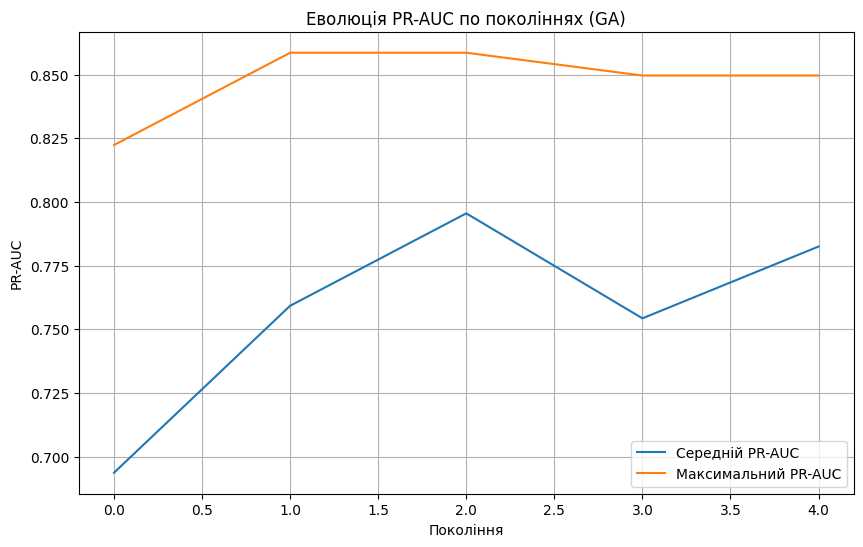

In [17]:
# Параметри GA (згідно з умовами)
POPULATION_SIZE = 10 # 8-12
GENERATIONS = 4      # 3-5
CXPB = 0.6           # Коефіцієнт кросоверу (приблизно 1.0 - мутація)
MUTPB = 0.35         # Коефіцієнт мутації (0.3-0.4)
ELITE_SIZE = 2       # Еліта 2

toolbox.register("evaluate", evaluate)

print("\n--- 5. Генетичний Алгоритм (GA): Пошук ---")

pop = toolbox.population(n=POPULATION_SIZE)
hof = tools.HallOfFame(1) # Hall of Fame для найкращої хромосоми
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)

# Виконання основного алгоритму GA
pop, log = algorithms.eaSimple(
    pop, toolbox,
    cxpb=CXPB,
    mutpb=MUTPB,
    ngen=GENERATIONS,
    stats=stats,
    halloffame=hof,
    verbose=True
)

# Найкраща хромосома (це список ІНДЕКСІВ)
best_individual_indices = hof[0]

# Декодування індексів у реальні значення параметрів
best_params = {
    'h1': CHOICES[0][best_individual_indices[0]],
    'h2': CHOICES[1][best_individual_indices[1]],
    'dropout': CHOICES[2][best_individual_indices[2]],
    'l2': CHOICES[3][best_individual_indices[3]],
    'lr': CHOICES[4][best_individual_indices[4]],
    'batch': CHOICES[5][best_individual_indices[5]]
}

print("\n--- 5. GA: Найкраща конфігурація (Параметри) ---")
print(best_params)

# Графік еволюції (для звіту)
gen = log.select("gen")
avg = log.select("avg")
max_fit = log.select("max")

plt.figure(figsize=(10, 6))
plt.plot(gen, avg, label="Середній PR-AUC")
plt.plot(gen, max_fit, label="Максимальний PR-AUC")
plt.title("Еволюція PR-AUC по поколіннях (GA)")
plt.xlabel("Покоління")
plt.ylabel("PR-AUC")
plt.legend()
plt.grid(True)
plt.savefig('ga_evolution.png')
#
print("Графік еволюції збережено як ga_evolution.png")


--- 6. Фінальна модель: Донавчання ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1336/1336 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

--- 6. Оптимізована модель: Результати ---
Оптимізований PR-AUC (Test): 0.7614
Оптимізований F1 (Test): 0.7727

--- 7. Порівняльна Таблиця Метрик ---
               Поріг  Val PR-AUC  Test PR-AUC  Val ROC-AUC  Test ROC-AUC  \
Базова        0.9954      0.8603       0.7692       0.9761        0.9628   
Оптимізована  0.9981      0.8532       0.7614       0.9713        0.9314   

              Val F1  Test F1  
Базова        0.8824   0.7368  
Оптимізована  0.8400   0.7727  
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1336/1336 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
PR-крива збережена як pr_curve.png

--- 8. Висновки для Звіту ---
Найкраща конфігурація (з GA): {'h1': 128, 'h2': 80, 'dropout': 0.0, 'l2': 0.0005, 'lr': 0.0007, 'batch': 1024}
Робочий поріг (Оптимізована): 0.9981
МЕТА НЕ ДОСЯГНУТА: Базова модель краща або рівна за PR-AUC на Test.


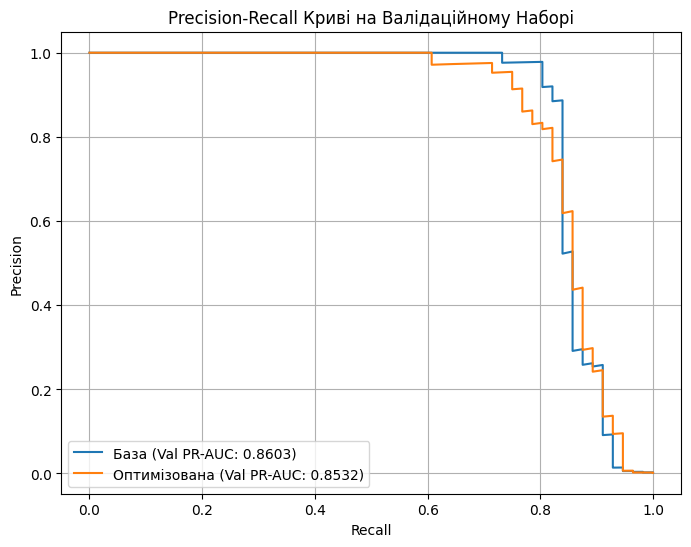

In [18]:
# 6.1 Фінальне донавчання найкращої моделі
EPOCHS_FINAL = 70 # 60-80

print("\n--- 6. Фінальна модель: Донавчання ---")

final_model = create_mlp(
    h1=best_params['h1'],
    h2=best_params['h2'],
    dropout_rate=best_params['dropout'],
    l2_reg=best_params['l2'],
    learning_rate=best_params['lr']
)

# Early Stopping для фінального навчання
final_es = EarlyStopping(
    monitor='val_pr_auc',
    patience=5, # Можна 5-7
    mode='max',
    restore_best_weights=True
)

final_history = final_model.fit(
    X_train_scaled, y_train_np,
    epochs=EPOCHS_FINAL,
    batch_size=best_params['batch'],
    validation_data=(X_val_scaled, y_val_np),
    class_weight=class_weight,
    callbacks=[final_es],
    verbose=0
)

# 6.2 Оцінка Фінальної моделі
final_metrics = evaluate_model(
    final_model,
    X_val_scaled, y_val_np,
    X_test_scaled, y_test_np
)

results['Оптимізована'] = final_metrics

print("\n--- 6. Оптимізована модель: Результати ---")
print(f"Оптимізований PR-AUC (Test): {final_metrics['test_pr_auc']:.4f}")
print(f"Оптимізований F1 (Test): {final_metrics['test_f1']:.4f}")

# 6.3 Порівняльна Таблиця
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df[['threshold', 'val_pr_auc', 'test_pr_auc', 'val_roc_auc', 'test_roc_auc', 'val_f1', 'test_f1']]
comparison_df.columns = ['Поріг', 'Val PR-AUC', 'Test PR-AUC', 'Val ROC-AUC', 'Test ROC-AUC', 'Val F1', 'Test F1']

print("\n--- 7. Порівняльна Таблиця Метрик ---")
print(comparison_df.round(4))

# 6.4 PR-крива (для звіту)
plt.figure(figsize=(8, 6))

# База
base_val_preds = base_model.predict(X_val_scaled).flatten()
precision_b, recall_b, _ = precision_recall_curve(y_val_np, base_val_preds)
plt.plot(recall_b, precision_b, label=f"База (Val PR-AUC: {base_metrics['val_pr_auc']:.4f})")

# Оптимізована
final_val_preds = final_model.predict(X_val_scaled).flatten()
precision_f, recall_f, _ = precision_recall_curve(y_val_np, final_val_preds)
plt.plot(recall_f, precision_f, label=f"Оптимізована (Val PR-AUC: {final_metrics['val_pr_auc']:.4f})")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Криві на Валідаційному Наборі')
plt.legend()
plt.grid(True)
plt.savefig('pr_curve.png')
#
print("PR-крива збережена як pr_curve.png")

# 6.5 Висновок для Звіту
print("\n--- 8. Висновки для Звіту ---")
print(f"Найкраща конфігурація (з GA): {best_params}")
print(f"Робочий поріг (Оптимізована): {final_metrics['threshold']:.4f}")

if final_metrics['test_pr_auc'] > base_metrics['test_pr_auc']:
    print(f"МЕТА ДОСЯГНУТА: Оптимізована модель перевершила Базову за PR-AUC на Test.")
else:
    print(f"МЕТА НЕ ДОСЯГНУТА: Базова модель краща або рівна за PR-AUC на Test.")